# 二阶常系数齐次线性微分方程

一维谐振子模型的实质是二阶常系数齐次线性微分方程，可等效为1/4悬架模型、二阶LCR电路模型

![Figure1](Figure1.png)

在不考虑重力的情况下，设质量块的质量为$m$，弹簧的刚度为$k$，阻尼器的阻尼为$c$，任意时刻$t$质量块的相对位移为$y(t)$，则根据牛顿第二定律有
$$
m \dfrac{d^2 y}{d t^2} + c\dfrac{d y}{d t} + ky = 0 ~
$$
设初边值条件为
$$
\left. \frac{d y}{d t} \right|_{y=0} = 0 ~
$$
$$
y(0) = 1 ~
$$
令$ \delta = \frac{c}{2m} $，$ \omega_0 = \sqrt{ \frac{k}{m}} $，在欠阻尼的条件下$ \delta < \omega_0 $，则可得其解析解为
$$ 
y(t) = 2 A e^{- \delta t} \cos{ (\omega t + \phi) } ~
$$
其中，$ \omega = \sqrt{ \omega^2_0 + \delta^2} $，$ \phi = \arctan(-\frac{\delta}{\omega}) $，$ A = \frac{1}{2\cos \phi} = \frac{\omega_0}{2 \sqrt{ \omega^2_0 - \delta ^2 } }$

设$ m=1 , k=400, c=4 $，忽略单位问题，则精确解为

$$
y(t) = \frac{5 \sqrt{11}}{33} e^{-2t} \cos(6 \sqrt{11} t - 0.1001674211615598)
$$

其中，三角函数为弧度制

以下将先求其解析解，然后用全连接神经网络（Fully connected neural network，FCNN）和物理信息神经网络（Physics-informed neural networks,PINN）来进行计算仿真。

# 预定义

In [1]:
# 相关库的导入，随机数/随机种子的定义

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    # 数据可视化库，主要用于画图
from PIL import Image    #　PIL/pillow图像处理库，具有图像打开和保存、图像显示、图像格式和大小转换、绘图和图像处理等功能，能支持多种图像格式

import torch
import torch.nn as nn

np.random.seed(2024)    # numpy随机种子
torch.manual_seed(2024)    # torch随机种子

In [2]:
# 新建文件夹png用于存放图片,gif用于存放动图
%mkdir png
%mkdir gif

# GPU计算
torch.__version__    # torch版本
print(torch.cuda.is_available())    # True或False
print(torch.cuda.device_count())    # 查看英伟达GPU数量,1表示有1个GPU
print(torch.cuda.current_device())    # 查看当前GPU索引号，索引号从0开始
print(torch.cuda.get_device_name(0))    # 根据索引号0查看GPU名字

if torch.cuda.is_available():
    device = torch.device("cuda")    # 支持GPU的话，指定设备

��Ŀ¼���ļ� png �Ѿ����ڡ�
��Ŀ¼���ļ� gif �Ѿ����ڡ�


True
1
0
NVIDIA GeForce 840M


In [3]:
# 定义gif动图保存函数、画图函数、谐振子解析函数

# 利用PIL定义gif动图保存函数
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]    # 从files中读取file, 打开图像使用Image.open("example.jpg")
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)    # 生成并保存gif图，image.save("example.jpg")


# 定义画图函数
def plot(t, y, yh, t_data, y_data, tp=None, axis_lim=1):
    plt.figure(figsize=(8,4))    # 定义画布大小
    plt.plot(t, y, color='grey', linewidth=2, alpha=0.8, label='Exact solution')    # 绘制精确解的折线图，plot:折线图，定义t、y为精确解的形参，alpha:透明度
    plt.plot(t, yh, color='tab:blue', linewidth=4, alpha=0.8, label='Neural network prediction')    # 绘制神经网络（包括FCNN和PINN）预测解的折线图，具体预测结果由后续函数定义和运算给出，h:hat,表预测
    plt.scatter(t_data, y_data, color='k', alpha=0.4, label='Training data')    # 绘制用于训练的数据的散点图，训练数据通常较少，可将训练数据画出，以便后续用于观察和评估训练效果
    if tp is not None:    # tp：物理损失训练位置，是可选参数，默认为None，不执行if下面的语句。当需要进行PINN仿真时，可将其赋值激活，画出参与PINN训练的x的位置，便于观察
        plt.scatter(tp, torch.zeros_like(tp), s=60, color='tab:green', alpha=0.4, label='Phys. loss train. locat.')    # 生成与tp形状相同的0张量，点的大小为60
    legend = plt.legend(loc="upper right", bbox_to_anchor=(1, 1), frameon=True, fontsize='large')    # 图例的位置loc设置和锚点位置bbox_to_anchor都设置为图表的右上角，即图例与图表重叠
    plt.setp(legend.get_texts(), color='k')    # 使用setp方法设置图例所有文本的属性
    if axis_lim==1:    # 后续可能改变轴限，能明确则明确，不能则不明确
        plt.xlim(-0.05, 1.05)
        plt.ylim(-1.1 , 1.1 )
        plt.text(0.2, 0.8 , "Train step: %i"%(i+1), fontsize="xx-large", color="k")
    elif axis_lim==2:
        plt.xlim(-0.05, 1.05)
        plt.ylim(-2.1 , 2.1 )
        plt.text(0.8, 0.8 , "Train step: %i"%(i+1), fontsize="xx-large", color="k")
    else:
        plt.text(0.2, 0.8 , "Train step: %i"%(i+1), fontsize="xx-large", color="k")
    plt.axis('on')
    plt.grid()


# 定义谐振子解析函数
def oscillator(m, k, c, t):    # m:质量，k:刚度，c:阻尼，t:时间
    delta  = c / m /2
    omega0 = torch.sqrt( k / m )
    omega  = torch.sqrt( omega0**2 - delta**2 )
    phi    = torch.arctan( -1 * delta / omega )    # 注：np的角度是弧度制，而Excel中的三角函数也是弧度制
    A      = 1 / 2 / torch.cos( phi )
    cos    = torch.cos( omega * t + phi )
    exp    = torch.exp( -1 * delta * t )
    x_t    = 2 * A * exp * cos
    return x_t

# 分析解

In [4]:
# 给谐振子参数赋值
m = 1
k = 400
c = 4

# 根据初边值条件计算过程参数
t0 = 0
delta  = c / m /2
omega0 = np.sqrt( k / m)    # 常数，用np，下同
omega  = np.sqrt( omega0**2 - delta**2 )
phi    = np.arctan( -1 * delta / omega )
A      = 1 / 2 / np.cos( phi )
cos    = np.cos( omega * t0 + phi)    # 代入t=0计算时，为常量，用np，下同
exp    = np.exp( -1 * delta * t0 )
x_t    = 2 * A * exp * cos

phi_deg = np.arctan(phi)*180/np.pi    # 弧度转角度

# 解析解的数学公式表示
print(f"5*sqrt(11)/33={5*np.sqrt(11)/33}, 6*sqrt(11)={6*np.sqrt(11)}, cos(phi)={np.cos(phi)}, 2Acos(phi)={2*A*np.cos(phi)}")    # 将无理数输出为数值
print(f"delta={delta}, omega0={omega0}, omega={omega}, phi={phi}, A={A}, 2A={2*A}, phi_deg={phi_deg}")    # 计算参数
print(f"y(t)={2*A}*EXP(-{delta}*t)*cos({omega}*t{phi}), x(0)={x_t}")    # 解析解表达式

5*sqrt(11)/33=0.5025189076296059, 6*sqrt(11)=19.8997487421324, cos(phi)=0.99498743710662, 2Acos(phi)=1.0
delta=2.0, omega0=20.0, omega=19.8997487421324, phi=-0.1001674211615598, A=0.502518907629606, 2A=1.005037815259212, phi_deg=-5.720090530434535
y(t)=1.005037815259212*EXP(-2.0*t)*cos(19.8997487421324*t-0.1001674211615598), x(0)=1.0


In [5]:
# 算出谐振子的解析解
m = torch.tensor(1.0, device=device)    # 转移到GPU计算，下同
k = torch.tensor(400, device=device)
c = torch.tensor(4.0, device=device)

t = torch.linspace(0,1,501).view(-1,1).to(device)    # t从0到1取500个数据，并转化为列向量
y = oscillator(m, k, c, t ).view(-1,1).to(device)    # 解出t时刻y的值
#print(f"t={t.view(1,-1)}")    # 数据太多，没法完全打印出来。同时考虑把数据保存到其它文件，如mat、Excel等
#print(f"y={y.view(1,-1)}")
plt.plot(t.cpu().numpy(), y.cpu().numpy())    # 把数据转移回CPU，然后画出精确解的图像
plt.grid(True)

# 将解析解保存到Excel文件
data = {'t':t.cpu().squeeze().numpy(), 'y_exact':y.cpu().squeeze().numpy()}    # 将torch格式的t和y_exact转换为NumPy数组，并存储在字典中。
df = pd.DataFrame(data)    # 将字典转换为pandas的DataFrame数据类型
df.to_excel('DataTest.xlsx', index=False)    # 将DataFrame保存到名为output.xlsx的Excel文件中，不保存索引。后续可将各神经网络仿真数据保存到同一份Excel中进行对比

       t   y_exact
0  0.000  1.000000
1  0.002  0.999202
2  0.004  0.996819
3  0.006  0.992866
4  0.008  0.987362


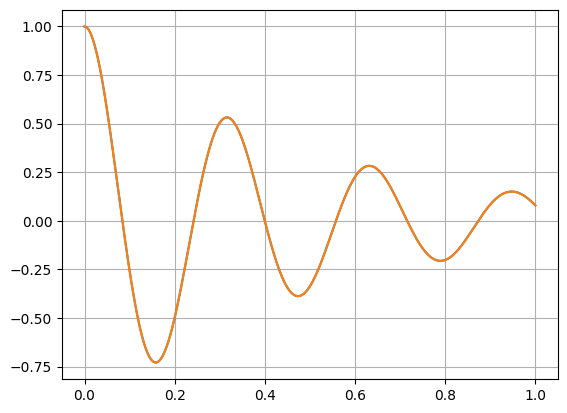

In [6]:
# 将上步保存的Excel数据提取出来，并可视化

file_path='DataTest.xlsx'
df1 = pd.read_excel(file_path)

print(df1.head())

t_p = df1['t'].values
y_p = df1['y_exact'].values

plt.plot(t_p,y_p)
plt.grid(True)
plt.show()

# 全连接神经网络

In [7]:
# 全连接神经网络（Fully connected neural network，FCNN）

class FCNN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()    # 继承父类 nn.Module 的初始化方法
        activation = nn.Tanh    # 激活函数选择tanh
        self.fcs = nn.Sequential(*[     # fcs:fully connected first stage, 表示输入层到第一个隐藏层,名称可自定义如self.input_layer。nn.Sequential是一个容器模块,用于按顺序组织多个神经网络层
            nn.Linear(N_INPUT, N_HIDDEN),     # 线性变换
            activation()])    # 激活函数
        self.fch = nn.Sequential(*[    # fch:fully connected hidden, 表示中间的隐藏层,类似self.hidden_layer。外层nn.Sequential：将所有内层的nn.Sequential对象按顺序组织在一起
            nn.Sequential( *[nn.Linear(N_HIDDEN, N_HIDDEN),     # 内层nn.Sequential, 解包操作*: 在nn.Sequential中使用*操作符将列表中的多个模块展开为nn.Sequential的参数
            activation()] ) 
            for _ in range(N_LAYERS-1)])    # 使用列表推导，创建 N_LAYERS-1 个隐藏层。_ 是一个占位符，表示不关心循环变量
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)    # fce: fully connected end, 表示最后一个隐藏层到输出层, 类似self.output_layer

    def forward(self,y):     # 前向传播方法，定义了输入数据如何通过网络的每一层
        y = self.fcs(y)      # 将输入数据通过输入层到第一个隐藏层的变换
        y = self.fch(y)      # 将数据通过所有中间的隐藏层
        y = self.fce(y)      # 将数据通过最后一个隐藏层到输出层的变换
        return y

torch.Size([501, 1]) torch.Size([501, 1])
torch.Size([10, 1]) torch.Size([10, 1])


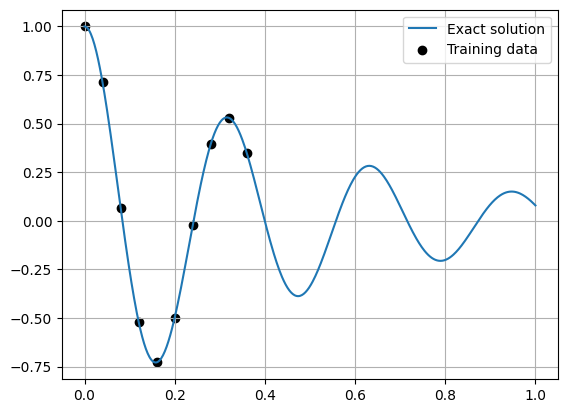

In [8]:
# 生成训练数据

t = torch.linspace(0,1,501).view(-1,1).to(device)    # t从0到1取500个数据，并转化为列向量
y = oscillator(m, k, c, t ).view(-1,1).to(device)    # 解出t时刻的y的值
print(t.shape, y.shape)    # 打印t、y的形状,torch.Size([501, 1])、torch.Size([501, 1])

t_data = t[0:200:20]    # 数组切片，t本来有500个数据，现从头200个数据中等距取10个数据,torch.Size([10, 1])
y_data = y[0:200:20]    # y切片,torch.Size([10, 1])

print(t_data.shape, y_data.shape)    # 核验训练数据

# 训练数据可视化
plt.plot(t.cpu(), y.cpu(), label='Exact solution')
plt.scatter(t_data.cpu(), y_data.cpu(), color='k', label='Training data')
plt.legend()
plt.grid()
plt.show()

In [9]:
# 将训练数据保存到Excel文件

# 将解析解保存到Excel文件
data_training = {'t_data':t_data.cpu().squeeze().numpy(), 'y_data':y_data.cpu().squeeze().numpy()}    # 将torch格式的t和y_exact转换为NumPy数组，并存储在字典中。
df = pd.DataFrame(data_training)    # 将字典转换为pandas的DataFrame数据类型
df.to_excel('DataTestTraining.xlsx', index=False)    # 将DataFrame保存到名为output.xlsx的Excel文件中，不保存索引。后续可将各神经网络仿真数据保存到同一份Excel中进行对比

"""
file_path = 'DataTest.xlsx'
df = pd.read_excel(file_path)
df['t_data'] = t_data.cpu().squeeze().numpy()
df['y_data'] = y_data.cpu().squeeze().numpy()
df.to_excel(file_path, index=False)
"""

"\nfile_path = 'DataTest.xlsx'\ndf = pd.read_excel(file_path)\ndf['t_data'] = t_data.cpu().squeeze().numpy()\ndf['y_data'] = y_data.cpu().squeeze().numpy()\ndf.to_excel(file_path, index=False)\n"

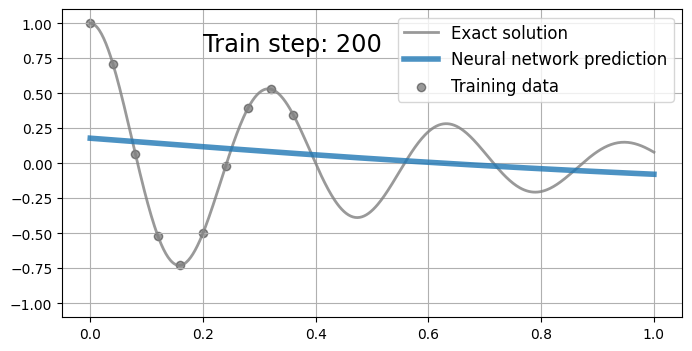

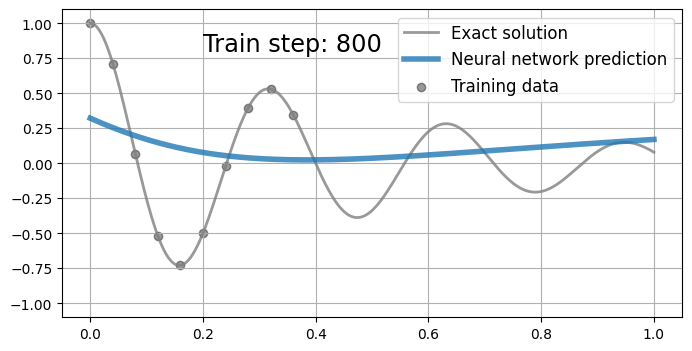

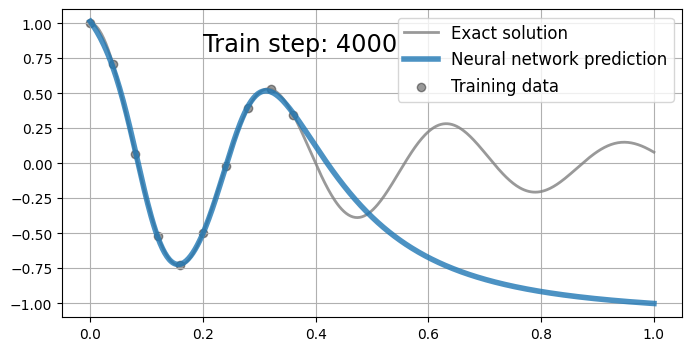

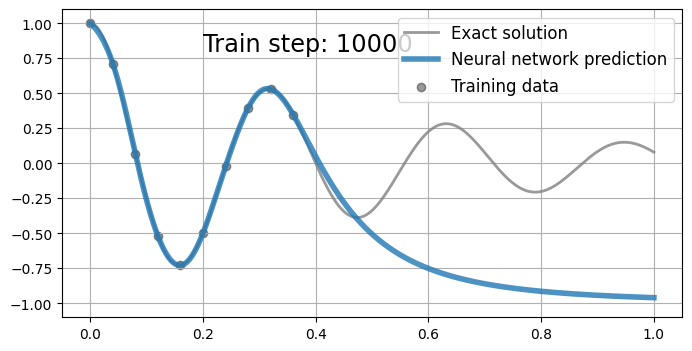

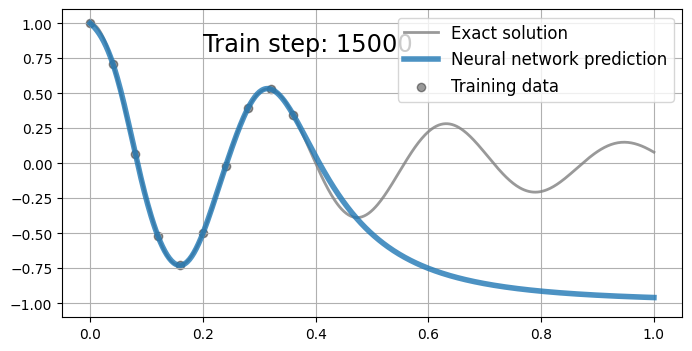

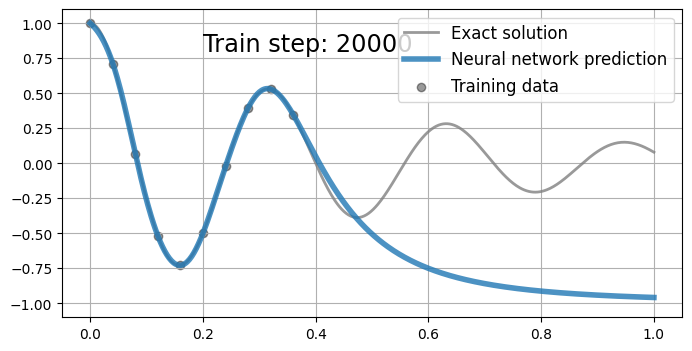

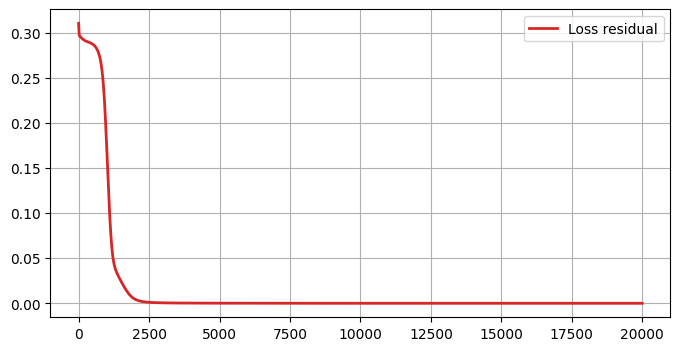

In [10]:
# FCNN全连接神经网络的训练

model = FCNN(1,1,32,3).to(device)    # 1输入、1输出、3层隐藏层，每层32个神经元
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)    # 定义优化器，使用Adam优化器

files=[]    # 初始化文件列表
loss_values = []    # 初始化损失函数的残差

train_number = 20000
for i in range(train_number):    # 科学计数法是float型数据，不能用于range()
    optimizer.zero_grad()    # 将梯度清零，避免累计
    yh = model(t_data)    # 将10个训练数据t_data扔入FCNN网络进行训练，前向传播，得到的预测结果赋值给yh
    loss = torch.mean((yh - y_data)**2)    # 定义损失函数，计算预测结果yh与训练数据y_data的均方差
    loss.backward()    # 反向传播，计算梯度
    optimizer.step()    # 更新模型参数

    loss_values.append(loss.item())

    # 训练过程可视化
    if (i+1) % 200 == 0:    # 每跑200个数据就绘图，从第1个数据开始
        yh = model(t).detach()    # 使用模型对输入t进行前向传播，并将结果与计算图分离，防止内存泄漏
        
        yh_cpu= yh.cpu()    # 将数据从GPU移动到CPU，用于画图，下同
        t_cpu = t.cpu()
        y_cpu = y.cpu()
        t_data_cpu = t_data.cpu()
        y_data_cpu = y_data.cpu()

        plot(t_cpu, y_cpu, yh_cpu, t_data_cpu, y_data_cpu)    # 调用自定义的绘图函数plot，绘制训练数据、精确值和神经网络预测值

        file = "png/FCNN_%.8i.png" % (i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files.append(file)

        if (i+1) in [200, 800, 4000, 10000, 15000, 20000]:
            plt.show()
        else:
            plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(range(1, train_number+1), loss_values, label='Loss residual', color='tab:red', linewidth=2)    # 绘制损失函数的残差曲线
plt.legend()
plt.grid()
plt.show()

save_gif("gif/FCNN.gif", files, fps=20, loop=0)

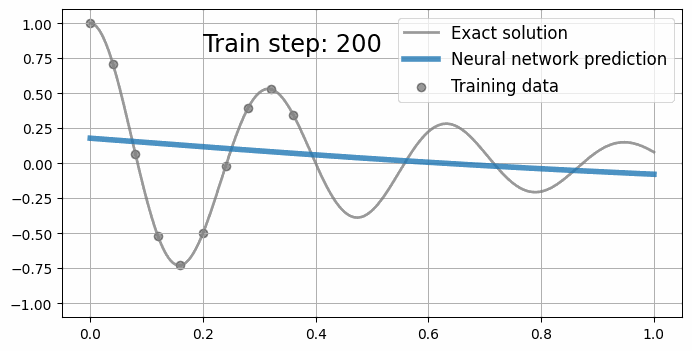

In [11]:
import IPython.display as ipd
ipd.Image("gif/FCNN.gif")

In [12]:
# 将FCNN的预测数据保存到Excel文件

file_path = 'DataTest.xlsx'
df = pd.read_excel(file_path)
df['t_FCNN'] = t_cpu.squeeze().numpy()
df['yh_FCNN'] = yh_cpu.squeeze().numpy()
df.to_excel(file_path, index=False)

## 对照实验

In [13]:
# 不同的训练数据对FCNN预测的影响

t_data_sparse = t[0:500:50]
y_data_sparse = y[0:500:50]

print(t_data_sparse.shape, y_data_sparse.shape)

torch.Size([10, 1]) torch.Size([10, 1])


# 物理信息神经网络

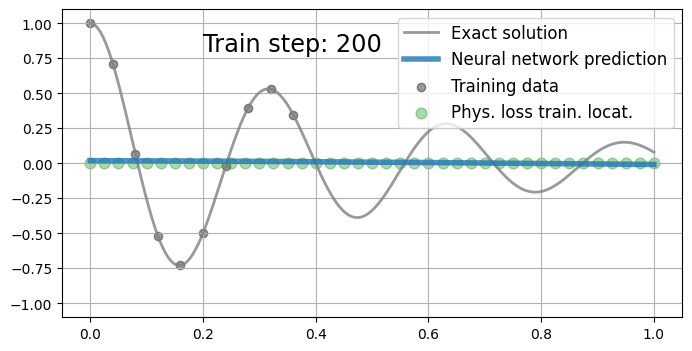

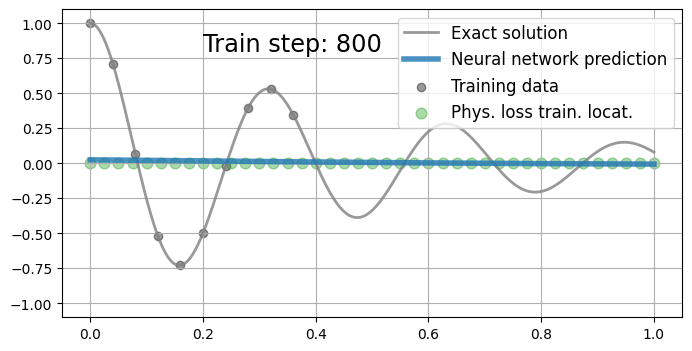

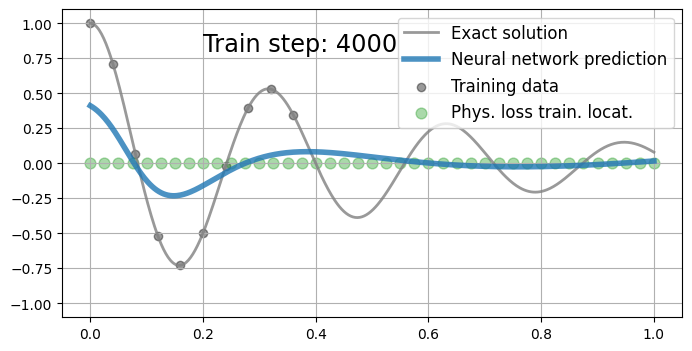

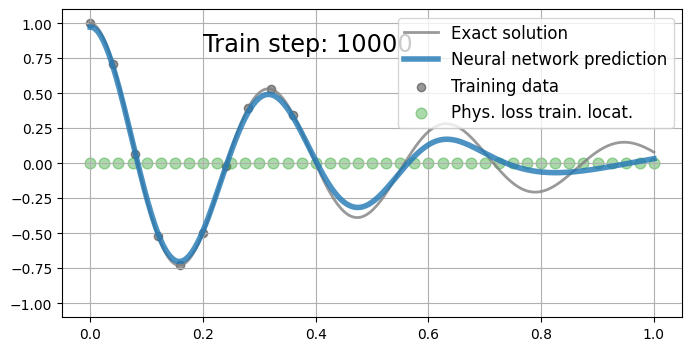

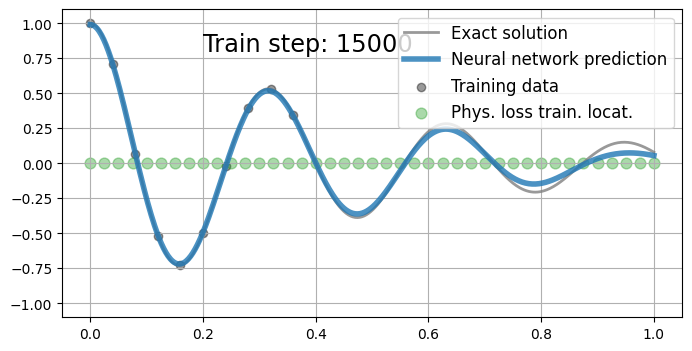

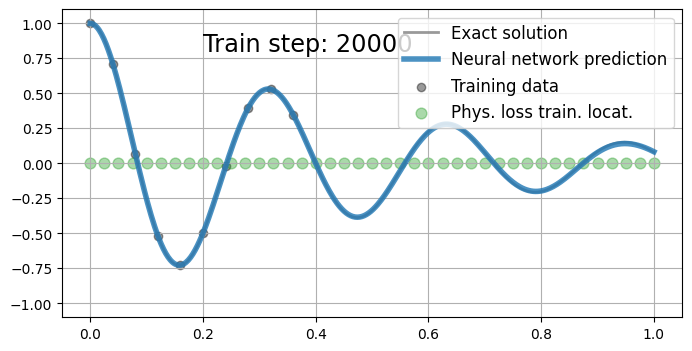

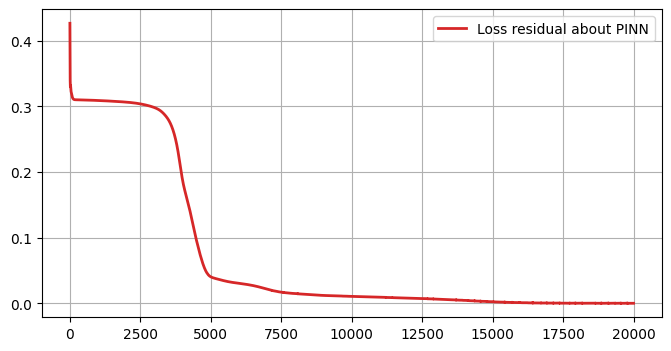

In [14]:
# 将微分方程添加到损失函数，即物理损失

t_physics = torch.linspace(0,1,41).view(-1,1).requires_grad_(True).to(device)    # 在[0,1]上均匀分布41个物理损失的观测点，设置张量需要计算梯度

# 神经网络仍然使用前述的FCNN，优化器设置相同，训练数据也相同

t0 = t_physics[:1,:].requires_grad_(True)    # 定义初始条件



# FCNN全连接神经网络+物理损失的定义和训练

model = FCNN(1,1,32,3).to(device)    # 1输入、1输出、3层隐藏层，每层32个神经元
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)    # 定义优化器，使用Adam优化器

files=[]    # 初始化文件列表
loss_values = []    # 初始化损失函数的残差

train_number = 20000
for i in range(train_number):    # 科学计数法是float型数据，不能用于range()
    optimizer.zero_grad()    # 将梯度清零，避免累计
    yh = model(t_data)    # 将10个训练数据t_data扔入FCNN网络进行训练，前向传播，得到的预测结果赋值给yh
    loss1 = torch.mean((yh - y_data)**2)    # 定义 数据 损失函数，计算预测结果yh与训练数据y_data的均方差


    # 以下是物理损失的定义和计算
    # 计算微分方程的损失函数
    yhp = model(t_physics)
    dy  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]    # 计算观测点的一阶微分
    dy2 = torch.autograd.grad(dy , t_physics, torch.ones_like(dy ), create_graph=True)[0]    # 计算观测点的二阶微分
    physics= m*dy2 + c*dy + k*yhp    # 计算谐振子微分方程的残差
    loss2 = (1e-4)*torch.mean(physics**2)    # 定义并计算微分方程的损失函数
    # 计算初边值条件的损失函数
    y0 = model(t0)    # 计算初边值条件1
    dy0dx = torch.autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]    # 计算初边值条件2
    loss3 = (1e-4)*torch.mean(dy0dx**2)
    # 损失函数累加
    loss = loss1 + loss2 + loss3
    # 以上是物理损失的定义和计算


    loss.backward()    # 反向传播，计算梯度
    optimizer.step()    # 更新模型参数

    loss_values.append(loss.item())

    # 训练过程可视化
    if (i+1) % 200 == 0:    # 每跑200个数据就绘图，从第1个数据开始
        yh = model(t).detach()    # 使用模型对输入t进行前向传播，并将结果与计算图分离，防止内存泄漏

        tp = t_physics.detach()    # 激活前述定义的plot画图函数的物理损失部分
        
        yh_cpu= yh.cpu()    # 将数据从GPU移动到CPU，用于画图，下同
        t_cpu = t.cpu()
        y_cpu = y.cpu()
        t_data_cpu = t_data.cpu()
        y_data_cpu = y_data.cpu()

        plot(t_cpu, y_cpu, yh_cpu, t_data_cpu, y_data_cpu, tp.cpu())    # 调用自定义的绘图函数plot，绘制训练数据、精确值和神经网络预测值

        file = "png/PINN_%.8i.png" % (i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files.append(file)

        if (i+1) in [200, 800, 4000, 10000, 15000, 20000]:
            plt.show()
        else:
            plt.close('all')


plt.figure(figsize=(8, 4))
plt.plot(range(1, train_number+1), loss_values, label='Loss residual about PINN', color='tab:red', linewidth=2)    # 绘制损失函数的残差曲线
plt.legend()
plt.grid()
plt.show()

save_gif("gif/PINN.gif", files, fps=20, loop=0)

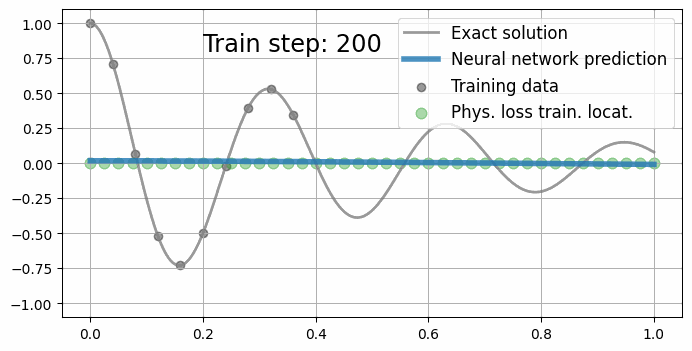

In [15]:
ipd.Image("gif/PINN.gif")